In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)

sns.set_theme(style="whitegrid")

# EDA


In [ ]:
print("--- Phase 1: Data Ingestion & First Look ---")

# We use a built-in dataset from Seaborn for this example.
df = pd.read_csv('./Titanic-Dataset.csv')

print(f"Dataset shape (rows, columns): {df.shape}\n")

print("First 10 rows (head):")
print(df.head(10))
print("\nLast 10 rows (tail):")
print(df.tail(10))

print("\nData types and non-null counts (info):")
df.info()

print(f"\nColumn names: {df.columns.tolist()}\n")

In [ ]:
print("\n--- Phase 2: Univariate Analysis ---")

print("\nDescriptive statistics for numerical features:")
print(df.describe())

plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Fare'])
plt.title('Fare Distribution (Box Plot)')
plt.xlabel('Fare')
plt.show()

print("\nValue counts for 'pclass':")
print(df['Pclass'].value_counts())

print("\nPercentage counts for 'embarked':")
print(df['Embarked'].value_counts(normalize=True))

plt.figure(figsize=(8, 5))
sns.countplot(x='Sex', data=df)
plt.title('Count of Passengers by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

In [ ]:
print("\n--- Phase 3: Bivariate & Multivariate Analysis ---")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Fare', data=df)
plt.title('Scatter Plot: Age vs. Fare')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.show()

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numeric_cols].corr()
print("\nCorrelation Matrix:")
print(corr_matrix)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Pclass', hue='Sex', data=df)
plt.title('Passenger Count by Pclass and Sex')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

print("\nCrosstab: Sex vs. Pclass")
print(pd.crosstab(df['Sex'], df['Pclass']))

plt.figure(figsize=(10, 6))
sns.boxplot(x='Pclass', y='Age', data=df)
plt.title('Age Distribution by Passenger Class')
plt.xlabel('Class')
plt.ylabel('Age')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Pclass', y='Survived', data=df)
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Class')
plt.ylabel('Survival Rate')
plt.show()

print("\nGenerating Pair Plot (can take a moment)...")
pairplot_cols = ['Survived', 'Age', 'Fare', 'Pclass']
sns.pairplot(df[pairplot_cols], hue='Survived', diag_kind='kde')
plt.suptitle('Pair Plot of Key Features by Survival', y=1.02)
plt.show()

In [ ]:
print("\n--- Phase 5: Documentation ---")
print("EDA complete. Review the plots and statistics.")
print("Example Insights Found:")
print("1. 'Age' has a relatively normal distribution, slightly skewed right.")
print("2. 'Fare' is extremely right-skewed; many cheap tickets and a few very expensive ones (outliers).")
print("3. Survival rate ('survived') is strongly correlated with 'pclass' (higher class, higher survival).")
print("4. 'Sex' is a very strong predictor; females had a much higher survival rate.")
print("5. 'Age' and 'Fare' have a very weak correlation.")

# Preprocessing


In [ ]:
print("Missing values per column:")
print(df.isnull().sum())

duplicate_count = df.duplicated().sum()
print(f"\nFound {duplicate_count} duplicate rows.")
if duplicate_count > 0:
    df = df.drop_duplicates()
    print("Dropped duplicate rows.")

In [ ]:
print("--- Phase 1: Setup and Data Splitting ---")


# For this example, we'll create one 'Cabin' feature from 'Cabin'
# and one 'Is_alone' feature to show feature engineering.
df['Cabin'] = df['Cabin'].astype(str).str[0]
df['Is_alone'] = (df['SibSp'] + df['Parch'] == 0).astype(int)

TARGET = 'Survived'

# We select the features we want to use.
# We drop 'alive', 'who', 'adult_male' (redundant)
# and 'embark_town', 'class' (duplicates of 'embarked', 'pclass')
# and 'sibsp', 'parch' (we combined them into 'Is_alone')
FEATURES = [
    'Pclass',    # Ordinal categorical
    'Sex',       # Nominal categorical
    'Age',       # Numerical with missing values
    'Fare',      # Skewed numerical
    'Embarked',  # Nominal categorical with missing values
    'Cabin',      # Nominal categorical with missing values ('n' for nan)
    'Is_alone'   # Numerical (binary)
]

X = df[FEATURES]
y = df[TARGET]

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}\n")

# --- Train-Test Split ---
# This is the MOST IMPORTANT step to do FIRST.
# We hold back 20% of the data for testing.
# We use 'stratify=y' to ensure the test set has the same
# proportion of survivors as the training set.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}\n")

In [ ]:
print("--- Phase 2: Building the Preprocessing Pipelines ---")

# We will build separate pipelines for each type of data.
# This makes the code clean and prevents errors.

# We first identify which columns belong to which group
# (This is a manual step based on our EDA)

# --- Sub-Pipeline 1: Numerical Features ---
# 'age', 'Fare'
# We will:
# 1. Impute missing values with the median (robust to outliers)
# 2. Scale the features using StandardScaler (makes mean=0, std=1)
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# --- Sub-Pipeline 2: Skewed Numerical Features ---
# Let's say we identified 'Fare' as highly skewed during EDA.
# We can create a separate pipeline for it.
# 1. Impute with median
# 2. Use PowerTransformer (Yeo-Johnson) to make it more "normal" (Gaussian-like)
# 3. Scale the result using StandardScaler
skewed_num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

# --- Sub-Pipeline 3: Nominal (Unordered) Categorical Features ---
# 'sex', 'embarked', 'Cabin'
# We will:
# 1. Impute missing values with the most_frequent value (mode)
# 2. One-Hot Encode the categories into new binary columns
nominal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    # 'handle_unknown='ignore'' prevents errors if a rare category
    # appears in the test set but not the train set.
])

# --- Sub-Pipeline 4: Ordinal (Ordered) Categorical Features ---
# 'pclass' (1st > 2nd > 3rd)
# We need to define the order explicitly
pclass_order = [1, 2, 3]
# We will:
# 1. Impute missing values (if any) with the mode.
# 2. Encode the categories as numbers (0, 1, 2)
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[
     pclass_order], handle_unknown='use_encoded_value', unknown_value=-1))
])

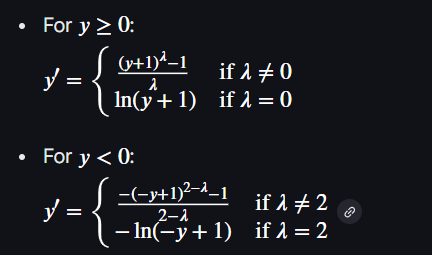


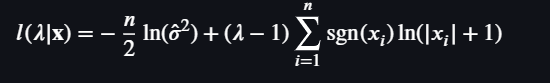


In [ ]:
print("--- Phase 3: Combining Pipelines with ColumnTransformer ---")

# First, let's define the lists of columns for each pipeline
# We'll treat 'Age' and 'Is_alone' as standard numerical
# We'll treat 'Fare' as skewed numerical
# We'll treat 'Pclass' as ordinal
# We'll treat 'Sex', 'Embarked', 'Cabin' as nominal

num_features = ['Age', 'Is_alone']
skewed_num_features = ['Fare']
ordinal_features = ['Pclass']
nominal_features = ['Sex', 'Embarked', 'Cabin']

# Now we create the master preprocessor
# This object will apply the right pipeline to the right columns
preprocessor = ColumnTransformer(
    transformers=[
        # (name, pipeline_object, column_list)
        ('numeric', numerical_pipeline, num_features),
        ('skewed_numeric', skewed_num_pipeline, skewed_num_features),
        ('ordinal', ordinal_pipeline, ordinal_features),
        ('nominal', nominal_pipeline, nominal_features)
    ],
    remainder='drop'  # 'drop' any columns not listed, 'passthrough' would keep them
)

In [ ]:
print("--- Phase 4: Fitting and Transforming the Data ---")

# --- Fit on Training Data ---
# We call .fit_transform() on the *training data only*
# This "learns" the medians, modes, scaling parameters, and categories
# from X_train and then transforms X_train.
print("Fitting preprocessor on X_train...")
X_train_preprocessed = preprocessor.fit_transform(X_train)
print("...Done.\n")

# --- Transform Test Data ---
# We call .transform() on the *test data*
# This applies the parameters *learned from the training set*
# to the test set. This prevents any data leakage.
print("Transforming X_test...")
X_test_preprocessed = preprocessor.transform(X_test)
print("...Done.\n")

print(f"Original X_train shape: {X_train.shape}")
print(f"Preprocessed X_train shape: {X_train_preprocessed.shape}")
print(f"Preprocessed X_test shape: {X_test_preprocessed.shape}")

In [ ]:
print("\n--- Phase 5: Inspecting the Preprocessed Output ---")

# The output is a NumPy array, which is what models want.
# But the column names are gone! Let's get them back.
# We can use the .get_feature_names_out() method

feature_names = preprocessor.get_feature_names_out()
print(f"Total {len(feature_names)} features after preprocessing:")
print(list(feature_names))

# Let's put the preprocessed data back into a DataFrame to see it
df_train_preprocessed = pd.DataFrame(
    X_train_preprocessed,
    columns=feature_names,
    index=X_train.index
)

print("\nHead of preprocessed training data:")
print(df_train_preprocessed.head())

print("\nDescriptive stats of preprocessed training data:")
# Note how 'numeric' and 'skewed_numeric' columns
# now have a mean very close to 0 and std dev of 1.
print(df_train_preprocessed.describe().round(2))

# Modeling


In [ ]:
print("--- Practical Step 3: Build, Train & Predict ---")

# We will create three separate, complete pipelines.
# Each pipeline combines the *preprocessor* with one *model*.
# This is the best practice.

# Model 1: K-Nearest Neighbors (KNN)
print("Building KNN pipeline...")
full_pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier(n_neighbors=5))
])

# Model 2: Logistic Regression
print("Building Logistic Regression pipeline...")
full_pipeline_log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=42, max_iter=1000))
])

# Model 3: Decision Tree
print("Building Decision Tree pipeline...")
full_pipeline_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42))
])

# --- Train All Models ---
print("\n--- Training all three models ---")

# Train KNN
print("Training KNN...")
full_pipeline_knn.fit(X_train, y_train)
print("...KNN training complete.")

# Train Logistic Regression
print("Training Logistic Regression...")
full_pipeline_log_reg.fit(X_train, y_train)
print("...Logistic Regression training complete.")

# Train Decision Tree
print("Training Decision Tree...")
full_pipeline_tree.fit(X_train, y_train)
print("...Decision Tree training complete.\n")


# --- Make Predictions on the Test Set ---
print("--- Making predictions on X_test ---")

# Predict with KNN
y_pred_knn = full_pipeline_knn.predict(X_test)

# Predict with Logistic Regression
y_pred_log_reg = full_pipeline_log_reg.predict(X_test)

# Predict with Decision Tree
y_pred_tree = full_pipeline_tree.predict(X_test)

print("...All predictions are complete.\n")


# --- Show Example Predictions ---
print("--- Example Predictions ---")
# Let's create a DataFrame to easily compare them
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'KNN_Prediction': y_pred_knn,
    'LogReg_Prediction': y_pred_log_reg,
    'Tree_Prediction': y_pred_tree
})

print("Comparison of actual values vs. model predictions (first 20 rows):")
print(predictions_df.head(20))

In [ ]:
# We will store our models and predictions in dictionaries for easy access
pipelines = {
    "KNN": Pipeline(steps=[('preprocessor', preprocessor), ('model', KNeighborsClassifier(n_neighbors=5))]),
    "LogisticRegression": Pipeline(steps=[('preprocessor', preprocessor), ('model', LogisticRegression(random_state=42, max_iter=1000))]),
    "DecisionTree": Pipeline(steps=[('preprocessor', preprocessor), ('model', DecisionTreeClassifier(random_state=42))])
}

predictions = {}
predictions_proba = {}  # For ROC curve

print("--- Training and Predicting ---")
for name, pipe in pipelines.items():
    print(f"Training {name}...")
    pipe.fit(X_train, y_train)
    # Get hard predictions (0 or 1)
    predictions[name] = pipe.predict(X_test)
    # Get probability predictions (for ROC)
    # We only want the probability of the positive class (1)
    if hasattr(pipe, "predict_proba"):
        predictions_proba[name] = pipe.predict_proba(X_test)[:, 1]
    else:
        # KNN doesn't have predict_proba by default in the same way, but we can get it
        predictions_proba[name] = pipe.predict_proba(X_test)[:, 1]

print("...All models trained and predictions made.\n")

# Evaluation


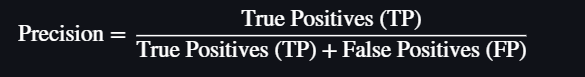


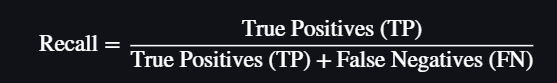


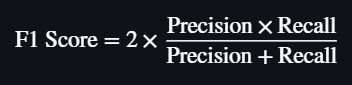


In [ ]:
print("--- Model Evaluation ---")

for name, y_pred in predictions.items():
    print(f"\n--- Results for {name} ---")

    # This gives you Precision, Recall, and F1-Score all at once!
    print("Classification Report:")
    print(classification_report(y_test, y_pred,
          target_names=["Died (0)", "Survived (1)"]))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Predicted Died", "Predicted Survived"],
                yticklabels=["Actual Died", "Actual Survived"])
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

print("\n--- ROC Curve Comparison ---")
plt.figure(figsize=(10, 8))

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')

for name, probas in predictions_proba.items():
    fpr, tpr, thresholds = roc_curve(y_test, probas)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


print("\n--- 10-Fold Cross-Validation (Robustness Check) ---")
# This runs the *entire* fit/predict process 10 times
# We use the full X and y, not the train/test split

for name, pipe in pipelines.items():
    # 'cv=10' means 10-fold
    # 'scoring='accuracy'' is what we'll measure
    scores = cross_val_score(pipe, X, y, cv=10, scoring='accuracy')

    print(f"Model: {name}")
    print(f"  All 10 scores: {np.round(scores, 3)}")
    print(f"  Mean Accuracy: {scores.mean():.3f}")
    print(f"  Std Deviation: {scores.std():.3f}")
    print("-" * 20)

# Advanced


In [ ]:
print("--- Practical Step 3: Build, Train & Predict (Advanced Models) ---")

# We will create a dictionary to hold our new models
# We use 'pipelines' to ensure preprocessing is identical
pipelines = {}

# Model 4: Random Forest
# Intuition: An "ensemble" model. It builds hundreds of
# different Decision Trees on random subsets of the data
# and features. To make a prediction, it takes a "majority vote"
# from all the trees. This fixes the overfitting problem of single trees.
print("Building Random Forest pipeline...")
pipelines['RandomForest'] = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
    # n_estimators=100 means build 100 trees
])

# Model 5: Support Vector Machine (SVM)
# Intuition: A "maximum margin" classifier. It tries to find the
# single best line (or hyperplane in high dimensions) that
# separates the classes with the *widest possible margin* or "street".
#
print("Building SVM pipeline...")
pipelines['SVM'] = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVC(random_state=42, probability=True))
    # *** CRITICAL ***: We *must* set probability=True
    # so we can get the scores needed for the ROC curve.
    # This can make it train slower.
])

# Model 6: Naive Bayes (Gaussian)
# Intuition: A fast, simple model based on probability (Bayes' Theorem).
# It's "naive" because it assumes all features are independent
# of each other (e.g., 'age' has no effect on 'Fare').
# We use 'GaussianNB' which assumes our continuous features
# (after scaling) are normally distributed (Gaussian).
print("Building Naive Bayes pipeline...")
pipelines['GaussianNB'] = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GaussianNB())
])

# --- Train and Predict (All Models) ---
predictions = {}
predictions_proba = {}  # For ROC curve

print("\n--- Training and Predicting for all models ---")
for name, pipe in pipelines.items():
    print(f"Training {name}...")
    pipe.fit(X_train, y_train)
    # Get hard predictions (0 or 1)
    predictions[name] = pipe.predict(X_test)
    # Get probability predictions (for ROC)
    predictions_proba[name] = pipe.predict_proba(X_test)[:, 1]

print("...All models trained and predictions made.\n")

In [ ]:
print("--- Model Evaluation (Advanced Models) ---")

for name, y_pred in predictions.items():
    print(f"\n==================== Results for {name} ====================")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred,
          target_names=["Died (0)", "Survived (1)"]))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Predicted Died", "Predicted Survived"],
                yticklabels=["Actual Died", "Actual Survived"])
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

print("\n--- ROC Curve Comparison ---")
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--',
         label='Random Guessing (AUC = 0.5)')  # 50/50 line

for name, probas in predictions_proba.items():
    fpr, tpr, thresholds = roc_curve(y_test, probas)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison (Advanced Models)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


print("\n--- 10-Fold Cross-Validation (Robustness Check) ---")

for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X, y, cv=10, scoring='accuracy')

    print(f"Model: {name}")
    print(f"  All 10 scores: {np.round(scores, 3)}")
    print(f"  Mean Accuracy: {scores.mean():.3f} (±{scores.std():.3f})")
    print("-" * 30)

print("\nEvaluation complete. You can now compare these results to the basic models.")